### CNN 기법을 이용한 안면(얼굴) 인식

In [1]:
# 글꼴 설치전 런타임 환경 확인
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
# from google.colab import drive
# drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

Mounted at /content/drive


In [30]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import random
import datetime

import cvlib
import cv2
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/actor_cvlib' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

In [31]:
width=64
height=64

# 훈련용 데이터 생성기
# rescale=1./255: 실수형태로 정규화, 0~1 사이의 값
train_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        './train', # 파일이 있는 폴더, Colab은 절대 경로 명시해야 인식가능 
        target_size=(width, height), # 훈련데이터 크기
        batch_size=1,                # 이미지 1건씩 처리
        class_mode='categorical')    # 다중분류

# 검증용 데이터 생성기
vali_datagen = ImageDataGenerator(rescale=1./255)
 
vali_generator = vali_datagen.flow_from_directory(
        './validation',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
# 3 classes: ./train/circle, ./train/rectangle, ./train/triangle

Found 254 images belonging to 8 classes.
Found 73 images belonging to 8 classes.


In [32]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Conv2D(16, kernel_size = (3, 3), padding='same',
                 input_shape = (width, height, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달, 슬라이딩이 작동되어 파라미터수가 50%로 감소함 
model.add(MaxPooling2D(pool_size=(2, 2))) 

# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(20, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

cp = ModelCheckpoint(filepath='./Actor.h5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

start = time.time()

hist = model.fit(
    train_generator,
    epochs=30,
    validation_data = vali_generator,
    callbacks=[cp, es])

end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# Total params: 993,431 Colab gpu: 42 ~ 83s, GTX 1060: 45

# CPU: 
# Colab GPU: 198 초

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 20)                327700    
                                                                 
 dense_5 (Dense)             (None, 8)                 168       
                                                      

Epoch 25/30
254/254 [==============================] - ETA: 0s - loss: 3.3017e-05 - accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 0.87671
254/254 [==============================] - 3s 13ms/step - loss: 3.3017e-05 - accuracy: 1.0000 - val_loss: 0.4263 - val_accuracy: 0.8767
Epoch 26/30
253/254 [============================>.] - ETA: 0s - loss: 2.8058e-05 - accuracy: 1.0000
Epoch 26: val_accuracy did not improve from 0.87671
254/254 [==============================] - 3s 12ms/step - loss: 2.7949e-05 - accuracy: 1.0000 - val_loss: 0.4403 - val_accuracy: 0.8767
Epoch 27/30
254/254 [==============================] - ETA: 0s - loss: 2.4715e-05 - accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 0.87671
254/254 [==============================] - 3s 13ms/step - loss: 2.4715e-05 - accuracy: 1.0000 - val_loss: 0.4372 - val_accuracy: 0.8767
Epoch 28/30
251/254 [============================>.] - ETA: 0s - loss: 2.1294e-05 - accuracy: 1.0000
Epoch 28: val_accuracy improved 

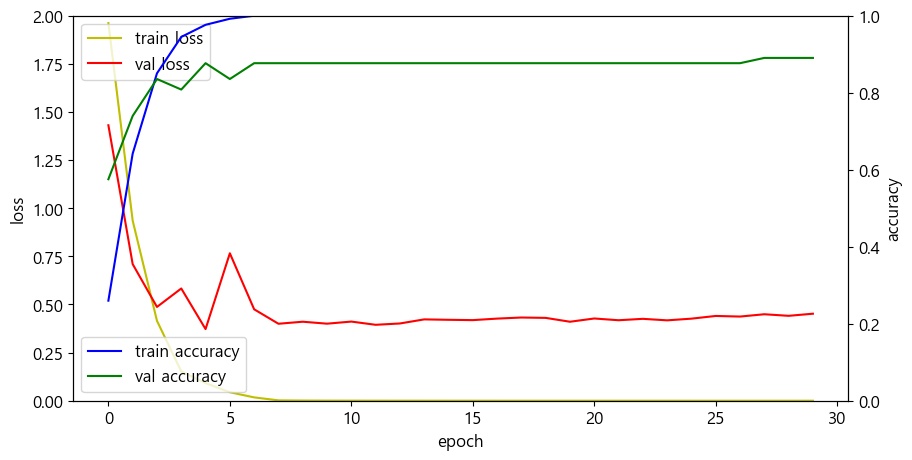

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 2.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [34]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=0)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 89.04%


In [35]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}, 알파벳 순
print(vali_generator.class_indices) # 분류에 할당된 index
print(type(output))
print(output.shape) # 검증 이미지가 70개, 7개의 분류임으로 출력은 70행 7열
print(output)

-- Predict --
{'Amanda Seyfried': 0, 'Andrew Lincoln': 1, 'Anne Hathaway': 2, 'Eom Giheung': 3, 'Hugh Jackman': 4, 'Keira Christina Knightley': 5, 'Pierce Brosnan': 6, 'Zo Jung Seok': 7}
<class 'numpy.ndarray'>
(73, 8)
[[0.997 0.000 0.000 0.000 0.000 0.003 0.000 0.000]
 [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000]
 [0.141 0.005 0.000 0.000 0.000 0.222 0.633 0.000]
 [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.966 0.000 0.000 0.000 0.000 0.033 0.000 0.000]
 [0.015 0.000 0.000 0.000 0.000 0.985 0.000 0.000]
 [0.999 0.000 0.000 0.000 0.000 0.001 0.000 0.000]
 [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.007 0.986 0.000 0.000 0.007 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.005 0.000 0.142 0.000 0.000 0.853 0.000 0.000]
 [0.000 0.000 0.

In [36]:
model.save('./Actor.h5')

In [37]:
model = load_model('./Actor.h5')

In [58]:
print(vali_generator.class_indices) # 분류에 할당된 index
def display(data):
    # print(data)
    # print(type(data))
    sw= np.argmax(data)
    # print('sw:', sw)

    if sw == 0:
        sw = 'Amanda Seyfried'
    elif sw == 1:
        sw = 'Andrew Lincoln'
    elif sw == 2:
        sw = 'Anne Hathaway'
    elif sw == 3:
        sw = 'Eom Giheung'        
    elif sw == 4:
        sw = 'Hugh Jackman'
    elif sw == 5:
        sw = 'Keira Christina Knightley'        
    elif sw == 6:
        sw = 'Pierce Brosnan'   
    elif sw == 7:
        sw = '조정석'

    return sw    

{'Amanda Seyfried': 0, 'Andrew Lincoln': 1, 'Anne Hathaway': 2, 'Eom Giheung': 3, 'Hugh Jackman': 4, 'Keira Christina Knightley': 5, 'Pierce Brosnan': 6, 'Zo Jung Seok': 7}


In [59]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test1',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Amanda Seyfried /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.996 0.000 0.000 0.000 0.000 0.004 0.000 0.000]]
타겟: Amanda Seyfried / Amanda Seyfried


In [60]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test2',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Andrew Lincoln /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000]]
타겟: Andrew Lincoln / Andrew Lincoln


In [61]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test3',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Anne Hathaway /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]]
타겟: Anne Hathaway / Anne Hathaway


In [62]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test4',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Keira Christina Knightley /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]]
타겟: Keira Christina Knightley / Keira Christina Knightley


In [63]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test5',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Pierce Brosnan /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.004 0.000 0.000 0.000 0.000 0.996 0.000]]
타겟: Pierce Brosnan / Pierce Brosnan


In [64]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test6',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 조정석 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000]]
타겟: 조정석 / 조정석


In [65]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test7',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Hugh Jackman /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.000 0.000 0.000 0.501 0.000 0.389 0.110]]
타겟: Hugh Jackman / Hugh Jackman


In [66]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test8',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: Eom Giheung /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000]]
타겟: Eom Giheung / Eom Giheung
